# Explore the ESC dataset

## Introduction
This notebook acts as the exploration of the dataset

## Goal 
Idea of the implementation, is to first look at the dataset and then create a new dataset that summarizes the data into something more suited for the "winner"-classification.

Potential columns:
1. Year, numeric <- what year
2. Country, numeric <- numeric country code
2. Semifinal, binary <- is it a semifinal?
3. Final, binary <- is it the final?
4. (**target**) Won, binary <- Did the country win?

### Additional notes
* We want the classifier to give probabilites.
* Give a prediction for this years ESC, how close were we?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("../DATA/eurovision_song_contest_1975_2018v2.csv")

In [3]:
data.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


In [4]:
data.shape

(46382, 8)

In [5]:
data.isnull().sum()

Year                      0
(semi-) final             0
Edition                   0
Jury or Televoting        0
From country              0
To country                0
Points                    0
Duplicate             44980
dtype: int64

**1403 rows are duplicate?**

In [6]:
data.dtypes

Year                   int64
(semi-) final         object
Edition               object
Jury or Televoting    object
From country          object
To country            object
Points                 int64
Duplicate             object
dtype: object

**looks like we will have to do some dummy-variables** 

# Understanding the different columns

## Year
At what year was the competition?

## (semi-) final
Was it finals or semifinals?
* f final
* sfX semi-final X

## Edition
concatenaed column of Year and (semi-)final column?
* YYYYFF, YYYY <- year, FF <- f or sfX

## Jury or Televoting
From where were the points assigned?
* J, jury
* T, Televoting

## From country
Which country gave the points
* "European country"
Maybe check if there has been any namechanges?

## To country
Which country recieved the points?
* "European contry"
**Assign numeric country codes instead of names?**

## Points
The number of points given

## Duplicate
is it country X to country X?
* x, yes
* NaN, no

In [7]:
data.loc[~data.Duplicate.isnull(),].head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
20,1975,f,1975f,J,Finland,Finland,0,x
40,1975,f,1975f,J,France,France,0,x
60,1975,f,1975f,J,Germany,Germany,0,x
80,1975,f,1975f,J,Ireland,Ireland,0,x


In [8]:
out = data.loc[~data.Duplicate.isnull(),].apply(lambda x: 1 if x["From country"] == x["To country"] else 0, axis=1)

In [9]:
out.mean()

1.0

**We should be able to drop these columns!**

In [10]:
data = data.loc[data.Duplicate.isnull(),data.columns[:-1]]

In [11]:
data.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points
1,1975,f,1975f,J,Belgium,Finland,0
2,1975,f,1975f,J,Belgium,France,2
3,1975,f,1975f,J,Belgium,Germany,0
4,1975,f,1975f,J,Belgium,Ireland,12
5,1975,f,1975f,J,Belgium,Israel,1


# Explore the total number of points!
*hue with the type of points*

In [12]:
# clean out trailing whitespaces!
data.columns = [d.strip() for d in data.columns]

### The average number of points given (per country to country)

In [15]:
data_final = data.loc[data["(semi-) final"] == "f",]

/home/robin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


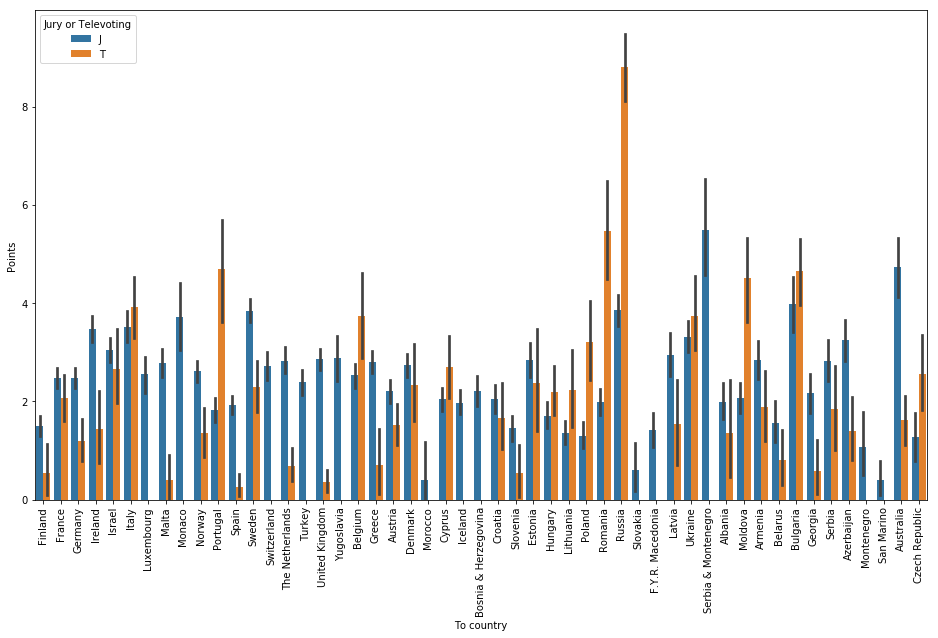

In [16]:
plt.figure(figsize=[16,9])
sns.barplot(data=data_final, x="To country", y="Points", hue="Jury or Televoting")
plt.xticks(rotation='vertical')
pass

### the total number of points recieved?

In [17]:
total_points = data_final.groupby(["To country", "Jury or Televoting"], as_index=False).Points.sum()
total_points.head()

,To country,Jury or Televoting,Points
0,Albania,J,630
1,Albania,T,58
2,Armenia,J,1121
3,Armenia,T,155
4,Australia,J,777


**should normalize the points, to its nicer to compare in plotting**

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler_j = MinMaxScaler()
scaler_t = MinMaxScaler()

In [19]:
Jpoints =scaler_j.fit_transform(np.array(total_points.loc[total_points["Jury or Televoting"] == "J",["Points"]]).reshape(-1,1))
Tpoints =scaler_t.fit_transform(np.array(total_points.loc[total_points["Jury or Televoting"] == "T",["Points"]]).reshape(-1,1))

/home/robin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/robin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
total_points.loc[total_points["Jury or Televoting"] == "J",["Points"]] = Jpoints
total_points.loc[total_points["Jury or Televoting"] == "T",["Points"]] = Tpoints

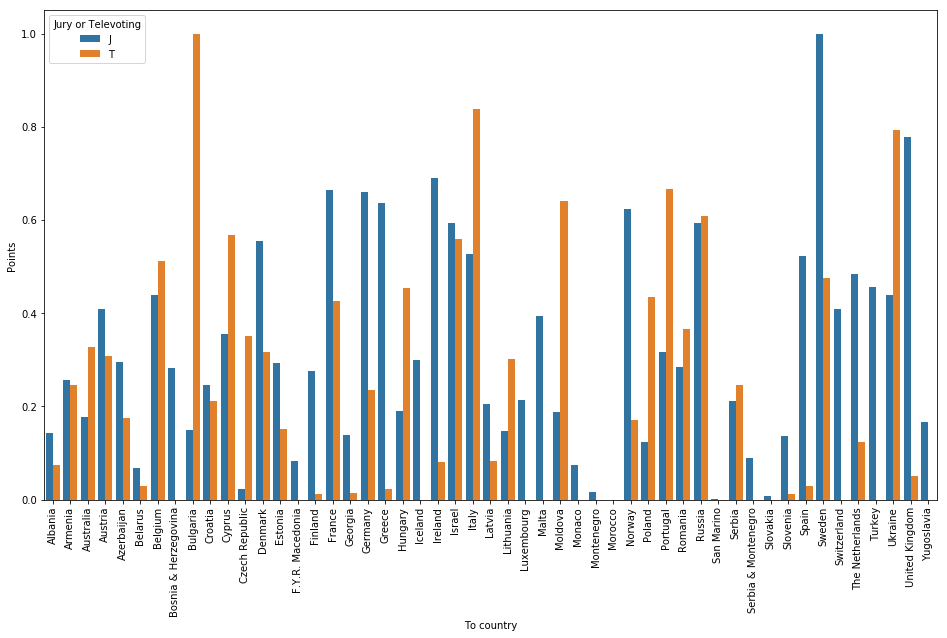

In [21]:
plt.figure(figsize=[16,9])
sns.barplot(data=total_points,
            x="To country",y="Points", hue="Jury or Televoting")
plt.xticks(rotation='vertical')
pass

### If we just group together all points

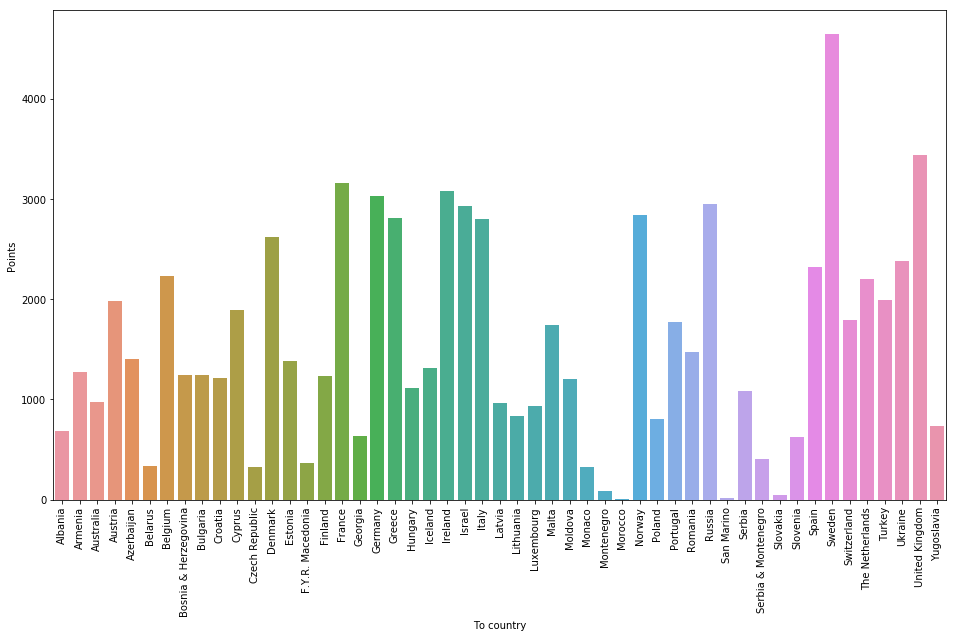

In [40]:
total_points = data_final.groupby(["To country"], as_index=False).Points.sum()

plt.figure(figsize=[16,9])
sns.barplot(data=total_points,x="To country", y="Points")
plt.xticks(rotation="vertical")
pass

## How many wins are there?
Per year and final, which country had the most points? <-- Winner
How many wins per country?

In [27]:
dt_group = data_final.groupby(["Year","To country"])["Points"].sum()

In [74]:
winnerid = dt_group.reset_index().groupby(["Year"])["Points"].apply(lambda x: x.idxmax())
winners = dt_group[winnerid].reset_index()
winners["To country"].value_counts()

Ireland            6
Sweden             4
Israel             4
United Kingdom     3
Norway             3
France             2
Denmark            2
Germany            2
Ukraine            2
Greece             1
Italy              1
Serbia             1
Latvia             1
Luxembourg         1
Estonia            1
Finland            1
The Netherlands    1
Turkey             1
Azerbaijan         1
Russia             1
Switzerland        1
Austria            1
Yugoslavia         1
Portugal           1
Belgium            1
Name: To country, dtype: int64

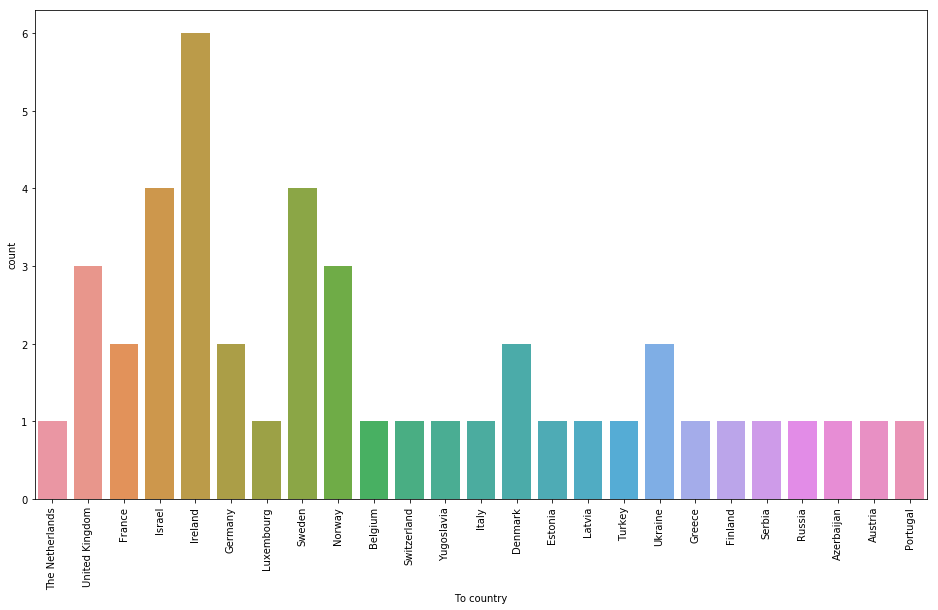

In [73]:
plt.figure(figsize=[16,9])
sns.countplot(data=winners, x= "To country")
plt.xticks(rotation="vertical")
pass